<a href="https://colab.research.google.com/github/sugar100/Section-Project/blob/main/AI_03_%EB%B0%B1%EC%84%A4_section02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas-profiling

In [ ]:

# google drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#df(=youtube trending dataset) 불러오기
df = pd.read_csv('/content/drive/MyDrive/KR_youtube_trending_data.csv')


# category name 생성
import json

with open('/content/drive/MyDrive/KR_category_id.json') as f:
  categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
  cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['categoryId'].map(cat_dict)

## 조회수 예측해보기

# Target : view_count


In [ ]:
df_you.head()

,view_count,likes,dislikes,comment_count
0,5947503,53326,105756,139946
1,963384,28244,494,3339
2,2950885,17974,68898,50688
3,1743374,36893,1798,8751
4,3433885,353337,9763,23405


In [ ]:
df["category_name"].loc[df["category_name"].isnull() == True] = "비영리/사회운동"

In [ ]:
# 필요없는 columns 삭제
df = df.drop(['video_id', 'channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'categoryId'], axis = 1)

# view_count, likes, dislikes, commen_count, categoryId 사용
df_you = df[['view_count', 'likes', 'dislikes', 'comment_count']]

# categoryId 변환
#df_you[['categoryId']] = df_you[['categoryId']].apply(pd.to_numeric)

In [ ]:
pip install pandas-profiling==2.8.0

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
profile = ProfileReport(df_you, title="Pandas Profiling Report")

In [ ]:
profile

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 분포 확인

In [ ]:
df_you.nunique() #고유값 확인

view_count       59854
likes            31899
dislikes          5453
comment_count    12805
dtype: int64

In [ ]:
df_you.describe()

,view_count,likes,dislikes,comment_count
count,6.115400e+04,6.115400e+04,61154.000000,6.115400e+04
mean,1.558779e+06,7.934694e+04,1389.715767,1.198177e+04
std,6.888353e+06,4.917039e+05,13923.119538,1.532819e+05
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,2.912010e+05,4.855000e+03,111.000000,6.170000e+02
50%,5.868305e+05,9.924000e+03,229.000000,1.386500e+03
75%,1.204480e+06,2.339700e+04,493.000000,3.357000e+03
max,2.963142e+08,1.646425e+07,879358.000000,6.939302e+06


In [ ]:
# 회귀 문제

In [ ]:
#타겟 분포 확인

sns.displot(df_you['view_count'], kde=True)

plt.axvline(df_you['view_count'].mean(), color='blue')
plt.axvline(df_you['view_count'].median(), color='red')

In [ ]:
plt.figure(figsize=(10,8))
sns.pairplot(data=df, x_vars=features, y_vars=['view_count'], height=5, aspect=0.75);
fig.tight_layout();

## 1. 중복값 제거

In [ ]:
df_you.duplicated().sum()  # 중복값 확인

158

In [ ]:
# 중복값 제거
df_you = df_you.drop_duplicates()

In [ ]:
df_you.duplicated().sum() #잘 제거 되었는 지 재확인

0

## 2. 이상치 확인 : view_count, dislikes, comment_count

Text(0.5, 0, '')

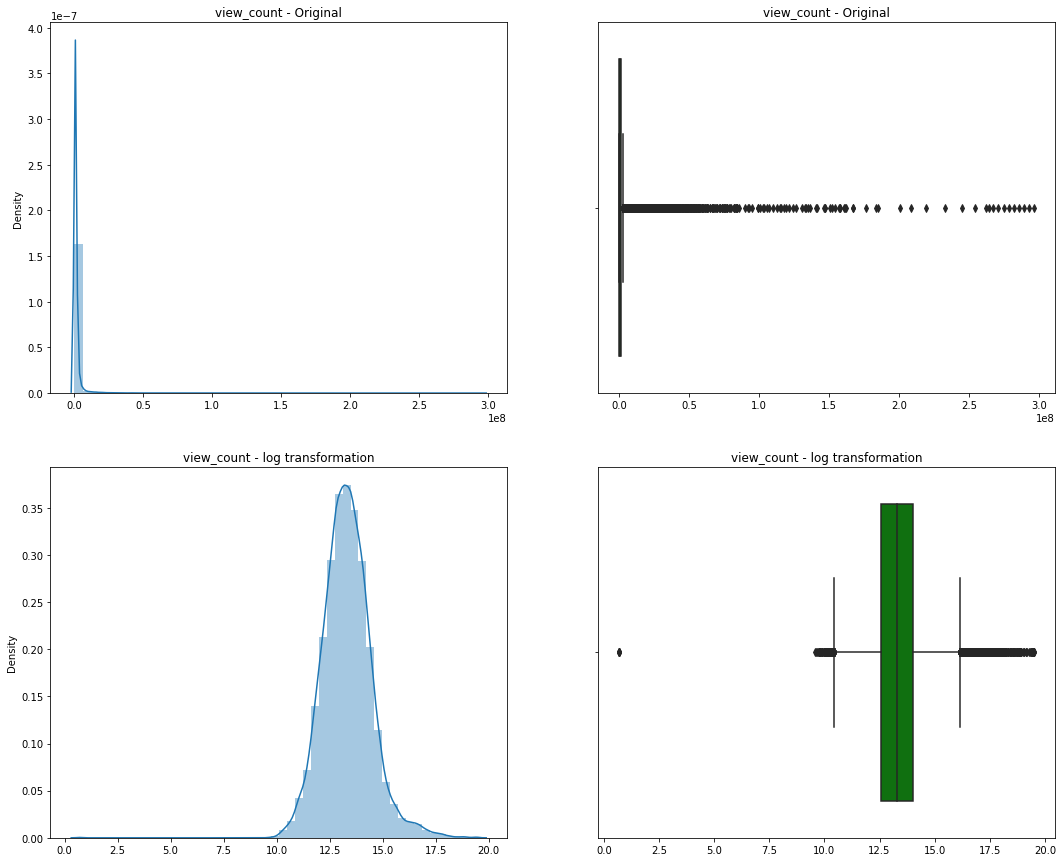

In [ ]:
# view_count

f,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.distplot(df_you['view_count'],kde=True, ax=ax[0,0])
ax[0,0].set_title('view_count - Original')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_you['view_count'],color='green',orient='h', ax=ax[0,1])
ax[0,1].set_title('view_count - Original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_you['view_count']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('view_count - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_you['view_count']+1),color='green',orient='h', ax=ax[1,1])
ax[1,1].set_title('view_count - log transformation')
ax[1,1].set_xlabel('')

Text(0.5, 0, '')

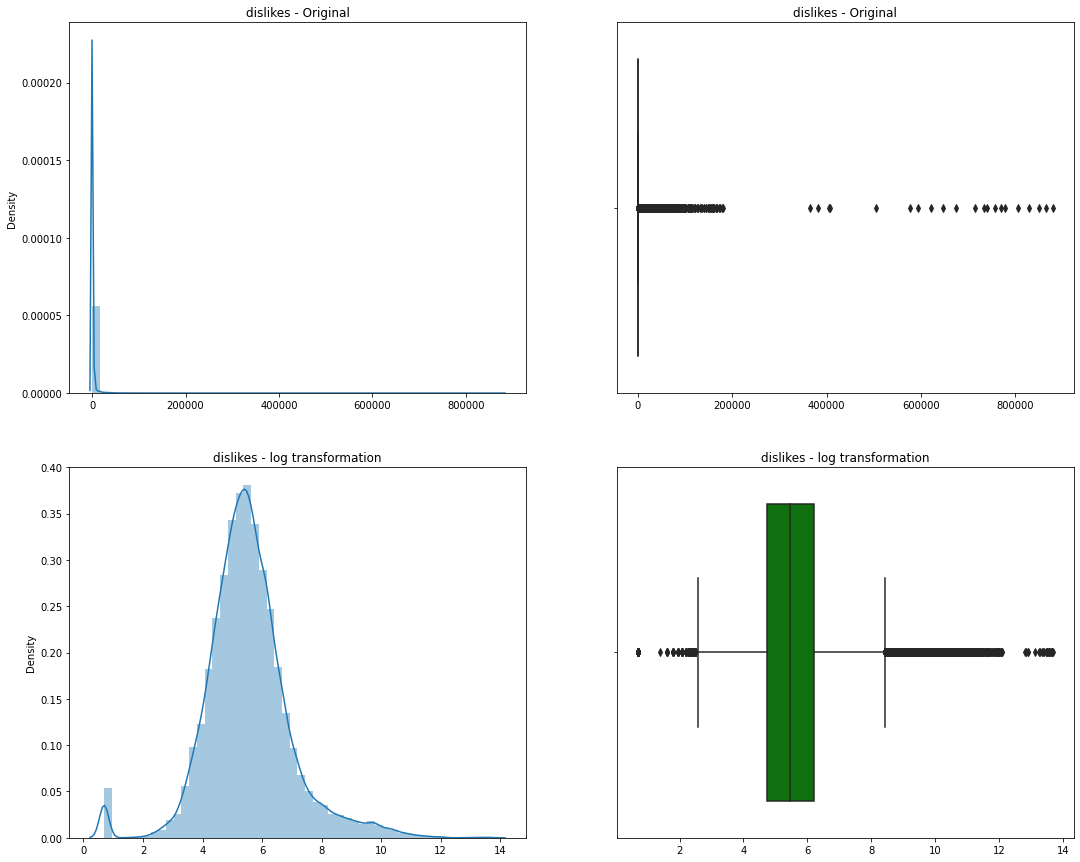

In [ ]:
# dislikes

f,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.distplot(df_you['dislikes'],kde=True, ax=ax[0,0])
ax[0,0].set_title('dislikes - Original')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_you['dislikes'],color='green',orient='h', ax=ax[0,1])
ax[0,1].set_title('dislikes - Original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_you['dislikes']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('dislikes - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_you['dislikes']+1),color='green',orient='h', ax=ax[1,1])
ax[1,1].set_title('dislikes - log transformation')
ax[1,1].set_xlabel('')

Text(0.5, 0, '')

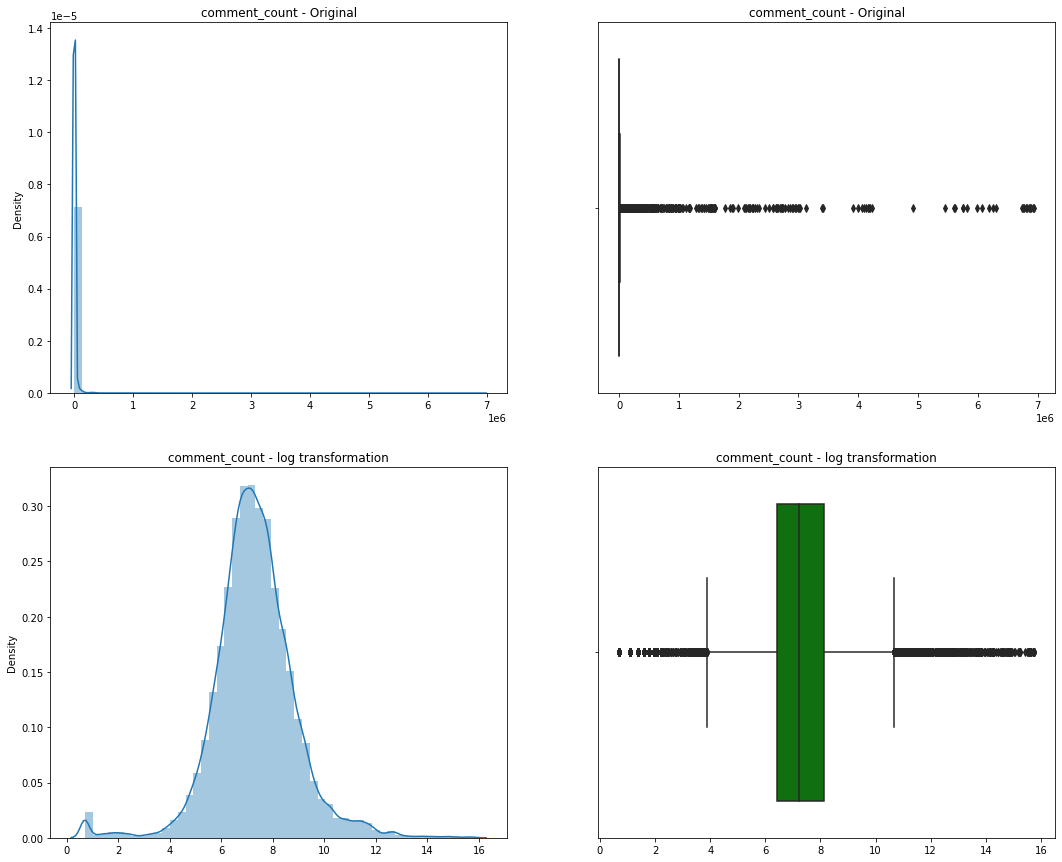

In [ ]:
# comment_count

f,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.distplot(df_you['comment_count'],kde=True, ax=ax[0,0])
ax[0,0].set_title('comment_count - Original')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_you['comment_count'],color='green',orient='h', ax=ax[0,1])
ax[0,1].set_title('comment_count - Original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_you['comment_count']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('comment_count - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_you['comment_count']+1),color='green',orient='h', ax=ax[1,1])
ax[1,1].set_title('comment_count - log transformation')
ax[1,1].set_xlabel('')

In [ ]:
columns = ['view_count','likes','dislikes','comment_count']

df_pre = df_you.copy()
for var in columns:
    df_pre['log_'+var]= (df_you[var]+1).apply(np.log)

## 3. 데이터 정규화

In [ ]:
# 데이터 정규화

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(df_you)

df_you_scaler = pd.DataFrame(x_scaled, columns=df_you.columns)

df_you_scaler

,view_count,likes,dislikes,comment_count
0,0.020072,0.003239,0.120265,0.020167
1,0.003251,0.001715,0.000562,0.000481
2,0.009959,0.001092,0.078350,0.007304
3,0.005884,0.002241,0.002045,0.001261
4,0.011589,0.021461,0.011102,0.003373
...,...,...,...,...
60991,0.002442,0.000252,0.000196,0.000097
60992,0.001911,0.000541,0.000313,0.000246
60993,0.001296,0.000196,0.000198,0.000033
60994,0.001839,0.000228,0.000098,0.000101


In [ ]:
df_you.describe()

,view_count,likes,dislikes,comment_count
count,60996.000000,60996.000000,60996.000000,60996.000000
mean,0.005269,0.004830,0.001584,0.001730
std,0.023276,0.029903,0.015854,0.022117
min,0.000000,0.000000,0.000000,0.000000
25%,0.000983,0.000295,0.000126,0.000089
50%,0.001983,0.000603,0.000260,0.000200
75%,0.004069,0.001424,0.000562,0.000485
max,1.000000,1.000000,1.000000,1.000000


## 4. train/val/test 나누기

In [ ]:
df_you = df_you.astype(np.int)

In [ ]:
df_you.dtypes

view_count       int64
likes            int64
dislikes         int64
comment_count    int64
dtype: object

In [ ]:
# target 선정
target = 'view_count'

features = ['likes','dislikes','comment_count']

# 훈련/검증/테스트 데이터 분리 (무작위로 데이터 나누기)

train, test = train_test_split(df_you, train_size = 0.8, test_size = 0.2, random_state = 2)


# 훈련 안에서 다시 검증 데이터 분리
train2, val = train_test_split(train, train_size = 0.8, test_size = 0.2, random_state = 2)

print("훈련 데이터 :", len(train2))
print("검증 데이터 :", len(val))
print("테스트 데이터 :", len(test))

훈련 데이터 : 39036
검증 데이터 : 9760
테스트 데이터 : 12200


In [ ]:
X_train = train2[features]
y_train = train2[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

## 5. 간단한 모델 학습

In [ ]:
# simple linear regression

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = regressor.predict(X_test)
np.exp(pred).round()

array([inf, inf, inf, ..., inf, inf, inf])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_regression(model, pred, X_train, y_train, X_test, y_test):
  print("MAE:", mean_absolute_error(y_test, pred))
  print("RMSE:", mean_squared_error(y_test, pred))
  print("R2:", r2_score(y_test, pred))


In [ ]:
pred = regressor.predict(X_test)

print('Coefficients: ', regressor.coef_)  #기울기
print('Intercept: ', regressor.intercept_)

eval_regression(regressor, pred, X_train, y_train, X_test, y_test)

Coefficients:  [ 8.18198556 49.22660666 13.90864969]
Intercept:  668094.3986590414
MAE: 817438.2009461365
RMSE: 6656227763069.319
R2: 0.853315894437052


## 6. Baseline Model

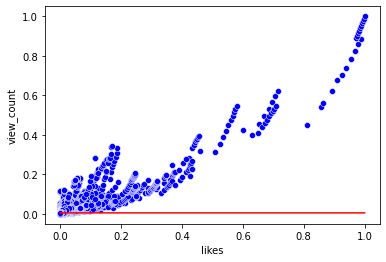

In [ ]:
x = df_you['likes']
y = df_you['view_count']

predict = df_you['view_count'].mean()
errors = predict - df_you['view_count']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='blue');

In [ ]:
print(f'예측한 조회수가 {predict}이며 절대평균에러가 {mean_absolute_error}임을 확인할 수 있습니다.')

예측한 조회수가 0.005269045864574114이며 절대평균에러가 0.005553431142762008임을 확인할 수 있습니다.


## Ridge Regression

In [ ]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
pred2 = ridge_model.predict(X_test)

print('Coefficients: \n', ridge_model.coef_) # The slope
print('Intercept: \n', ridge_model.intercept_) # The Intercept

eval_regression(ridge_model, pred2, X_train, y_train, X_test, y_test)

Coefficients: 
 [ 8.18198556 49.22660666 13.90864969]
Intercept: 
 668094.3986590427
MAE: 817438.2009461387
RMSE: 6656227763069.266
R2: 0.8533158944370532


## Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

alpha = [200, 230, 250,265, 270, 275, 290, 300, 500] # alpha
hyperparameters = dict(alpha=alpha)

from sklearn.linear_model import Ridge
ridge_model = Ridge()
clf = RandomizedSearchCV(ridge_model, hyperparameters, cv=5, random_state=30, scoring='r2')

#Fitting Model
best_model = clf.fit(X_train, y_train)

In [ ]:
pred = best_model.predict(X_test)
eval_regression(best_model, pred2, X_train, y_train, X_test, y_test)

MAE: 817438.2009461387
RMSE: 6656227763069.266
R2: 0.8533158944370532


## Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
eval_regression(dt, pred, X_train, y_train, X_test, y_test)

MAE: 476168.67613278684
RMSE: 4081745575651.702
R2: 0.9100500733731045


## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=104)
best_model1 = rf.fit(X_train, y_train)
pred = rf.predict(X_test)
eval_regression(rf, pred, X_train, y_train, X_test, y_test)

MAE: 409993.5401894755
RMSE: 2327571278151.774
R2: 0.9487070269794575


Text(0.5, 1.0, 'feature importance score')

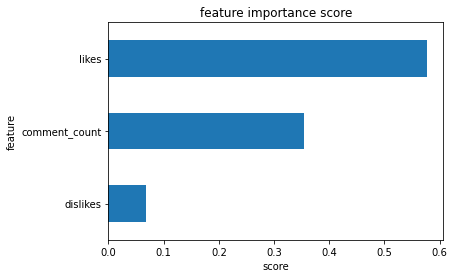

In [ ]:
#permutation importance

X=df_you[['likes','dislikes','comment_count']]
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

그래디언트 부스팅

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:5.67718e+06	validation_1-rmse:6.88459e+06
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.78289e+06	validation_1-rmse:5.80202e+06
[2]	validation_0-rmse:4.06492e+06	validation_1-rmse:4.92346e+06
[3]	validation_0-rmse:3.49149e+06	validation_1-rmse:4.24934e+06
[4]	validation_0-rmse:3.0161e+06	validation_1-rmse:3.65852e+06
[5]	validation_0-rmse:2.67137e+06	validation_1-rmse:3.22745e+06
[6]	validation_0-rmse:2.38202e+06	validation_1-rmse:2.89976e+06
[7]	validation_0-rmse:2.17404e+06	validation_1-rmse:2.6425e+06
[8]	validation_0-rmse:2.01056e+06	validation_1-rmse:2.45294e+06
[9]	validation_0-rmse:1.88831e+06	validation_1-rmse:2.32767e+06
[10]	validation_0-rmse:1.80686e+06	validation_1-rmse:2.232e+06
[11]	validation_0-rmse:1.72805e+06	validation_1-rmse:2.12892e+06
[12]	validation_0-rmse:1.68562e+06	validation_1-rmse:2.08193e+06
[13]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.9455019985907428


hyper parameter 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:

# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

X_test = test[features]

In [ ]:
param_grid = {
    'max_features' : ['sqrt', 0.25, 0.5],
    'max_depth' : [10, 20, 30, None]
}

grid = GridSearchCV(RandomForestRegressor(n_jobs = -1, n_estimators=200), param_grid, cv = 5, verbose = 1)
grid.fit(X_train_val, y_train_val)

print('best parameters : \n', grid.best_params_)
print('best score : ', grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 15.0min finished


best parameters : 
 {'max_depth': 30, 'max_features': 0.25}
best score :  0.9757176266461165


In [ ]:
from xgboost import XGBClassifier

pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

In [ ]:
#최적의 파라미터들을 선정하여 모델링
%%time

pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    PolynomialFeatures(2),
    RandomForestRegressor(n_jobs = -1, random_state = 10, n_estimators = 200, max_depth = 30 , max_features = 0.25, oob_score = True)
)

pipe.fit(X_train_val, y_train_val)

CPU times: user 53.1 s, sys: 875 ms, total: 54 s
Wall time: 28.9 s


In [ ]:
print('Training accuracy   : ', pipe.score(X_train, y_train))
print('Validation accuracy : ', pipe.score(X_val,y_val))

Training accuracy   :  0.9950377531786735
Validation accuracy :  0.9982237219966469
